# Imports and Loading

In [ ]:
# Loading the required libraries
%pip install nbimporter
import nbimporter
import feature_extraction
from feature_extraction import EmpathFeatureExtractor
from feature_extraction import NGramFeatureExtractor
from feature_extraction import EmpathFeatureAnalyzer
from feature_extraction import LDAFeatureExtractor
import os
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from collections import Counter
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
%store -r selected_categories

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Load documents and labels
folders = {
    "depression": {"path": "data/preprocessed_posts/depression", "label": 1},
    "breastcancer": {"path": "data/preprocessed_posts/breastcancer", "label": 0},
}
documents, labels = [], []
for category, data in folders.items():
    for file_name in os.listdir(data["path"]):
        file_path = os.path.join(data["path"], file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            documents.append(file.read())
            labels.append(data["label"])
print(f"Loaded {len(documents)} documents.")
print(f"Labels: {set(labels)}")

Loaded 1878 documents.
Labels: {0, 1}


In [15]:
class LDAFeatureAnalyzer:
    def __init__(self, lda_extractor):
        """
        Initialize the LDAFeatureAnalyzer.

        Parameters:
        lda_extractor (LDAFeatureExtractor): An instance of the LDAFeatureExtractor class.
        """
        self.lda_extractor = lda_extractor
        self.topic_matrix = None
        self.tsne_results = None

    def extract_topic_matrix(self):
        """
        Extract topic matrix from the LDAFeatureExtractor instance.
        """
        print("Extracting topic matrix...")
        self.topic_matrix = self.lda_extractor.topic_distribution_to_matrix()
        print(f"Topic matrix shape: {self.topic_matrix.shape}")

    def perform_tsne(self, perplexity=30, n_iter=500):
        """
        Perform t-SNE on the topic matrix to reduce it to 2D.

        Parameters:
        perplexity (int): t-SNE perplexity.
        n_iter (int): Number of iterations for t-SNE.
        """
        if self.topic_matrix is None:
            raise ValueError("Topic matrix is not extracted. Run extract_topic_matrix first.")

        print("Performing t-SNE...")
        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
        self.tsne_results = tsne.fit_transform(self.topic_matrix)
        print("t-SNE completed.")

    def visualize_tsne(self, labels=None):
        """
        Visualize the t-SNE results.

        Parameters:
        labels (list, optional): Labels to color-code the points in the plot.
        """
        if self.tsne_results is None:
            raise ValueError("t-SNE results are not available. Run perform_tsne first.")

        print("Visualizing t-SNE results...")
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(
            self.tsne_results[:, 0], self.tsne_results[:, 1], c=labels, cmap='viridis', s=10, alpha=0.7
        )
        if labels is not None:
            plt.legend(handles=scatter.legend_elements()[0], title="Labels")
        plt.title("t-SNE Visualization of LDA Topics")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.show()

    def analyze_topics(self, num_words=10):
        """
        Display the most significant words for each topic.

        Parameters:
        num_words (int): Number of top words to display for each topic.
        """
        print("Analyzing topics...")
        topics = self.lda_extractor.lda_model.show_topics(num_topics=-1, num_words=num_words, formatted=False)
        topic_words = {topic[0]: [word[0] for word in topic[1]] for topic in topics}

        for topic_id, words in topic_words.items():
            print(f"Topic {topic_id}: {', '.join(words)}")

    def cluster_topics(self, n_clusters=5):
        """
        Cluster the t-SNE results using KMeans.

        Parameters:
        n_clusters (int): Number of clusters for KMeans.

        Returns:
        np.ndarray: Cluster labels.
        """
        if self.tsne_results is None:
            raise ValueError("t-SNE results are not available. Run perform_tsne first.")

        print("Clustering t-SNE results...")
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(self.tsne_results)
        print("Clustering completed.")
        return clusters

    def run_analysis(self, perplexity=30, n_iter=500, n_clusters=5, labels=None):
        """
        Complete LDA feature analysis pipeline.

        Parameters:
        perplexity (int): t-SNE perplexity.
        n_iter (int): Number of iterations for t-SNE.
        n_clusters (int): Number of clusters for KMeans.
        labels (list, optional): Labels for t-SNE visualization.
        """
        self.extract_topic_matrix()
        self.perform_tsne(perplexity=perplexity, n_iter=n_iter)
        self.visualize_tsne(labels=labels)
        self.analyze_topics()
        clusters = self.cluster_topics(n_clusters=n_clusters)
        self.visualize_tsne(labels=clusters)


# Frequency and Predictive Power of N-gram Features

In [ ]:
# Extracting n-gram features
ngram_extractor = NGramFeatureExtractor(documents, labels)
ngram_extractor.extract_features()
depression_unigram_freqs, non_depression_unigram_freqs = ngram_extractor.compute_frequencies(feature_type="unigram")
depression_bigram_freqs, non_depression_bigram_freqs = ngram_extractor.compute_frequencies(feature_type="bigram")
top_100_depression_unigrams = ngram_extractor.get_top_n_features(depression_unigram_freqs, top_n=100)
print(top_100_depression_unigrams)
top_100_non_depression_unigrams = ngram_extractor.get_top_n_features(non_depression_unigram_freqs, top_n=100)
print(top_100_non_depression_unigrams)
top_100_depression_bigrams = ngram_extractor.get_top_n_features(depression_bigram_freqs, top_n=100)
print(top_100_depression_bigrams)
top_100_non_depression_bigrams = ngram_extractor.get_top_n_features(non_depression_bigram_freqs, top_n=100)
print(top_100_non_depression_bigrams)
ngram_extractor.visualize_wordcloud(depression_unigram_freqs, "Depression Unigram Word Cloud")
ngram_extractor.visualize_wordcloud(non_depression_unigram_freqs, "Non-Depression Unigram Word Cloud")
ngram_extractor.visualize_wordcloud(depression_bigram_freqs, "Depression Bigram Word Cloud")
ngram_extractor.visualize_wordcloud(non_depression_bigram_freqs, "Non-Depression Bigram Word Cloud")

# Predictive Power of Empath Features

In [3]:
# Analyzing the Empath model
empath_analyzer = EmpathFeatureAnalyzer(documents, labels, selected_categories)

# Run the pipeline
empath_analyzer.extract_empath_features()
empath_analyzer.analyze_correlation()
empath_analyzer.group_correlations_by_subcategory()

# Generate and visualize the summary table
summary_table = empath_analyzer.generate_summary_table()
empath_analyzer.visualize_summary_table()


Extracted Empath features with shape: (293, 237)
Removed constant columns: ['articles', 'auxiliary_verbs', 'adverbs', 'conjunctions', 'personal_pronouns', 'impersonal_pronouns', 'negations', 'prepositions', 'verbs', 'nouns', 'adjectives', 'comparatives', 'superlatives', 'modifiers', 'function_words', 'filler_words', 'verb_tense', 'slang', 'jargon', 'formal_language', 'casual_language', 'exclamations', 'contractions', 'word_complexity', 'sentiment_words', 'anxiety', 'hope', 'excitement', 'relief', 'gratitude', 'guilt', 'boredom', 'embarrassment', 'longing', 'nostalgia', 'frustration', 'melancholy', 'illness', 'fitness', 'nutrition', 'ingestion', 'physical_state', 'medicine', 'aging', 'disease', 'hospital', 'recovery', 'dieting', 'mental_health', 'drug_use', 'headache', 'fatigue', 'hormones', 'appetite', 'relationships', 'group_behavior', 'teamwork', 'community', 'peer_pressure', 'leadership', 'parenting', 'mentorship', 'marriage', 'divorce', 'gender_roles', 'social_identity', 'cultural_

# TODO: Predictive Power of LDA Features

Objective: Use Latent Dirichlet Allocation (LDA) to discover hidden topics in the posts, identifying themes associated with depression.

Process:
Train LDA models on the text data.
Generate topic distributions for each post (probability of belonging to each topic).
Select the top 20 topics with the largest proportions in the data.
Use t-SNE for dimensionality reduction to visualize topic clusters in 2D space.

Findings:
Topics indicative of depression include:
Themes like "Depression," "Broke," "Tired," "Pain," reflecting suffering, self-preoccupation, and low self-esteem.
Words associated with disclosure, loneliness, hostility, and interpersonal issues.

Significance: LDA captures latent patterns that are not explicitly defined (unlike LIWC), enabling nuanced analysis of depression-related themes.


Preprocessing documents...
Training LDA model...
Extracting topic distributions...
Saving features...
Saving file to: data/feature_extracted_data/lda_topic_distributions_with_labels.csv
Saved to data/feature_extracted_data/lda_topic_distributions_with_labels.csv.
Visualizing t-SNE...


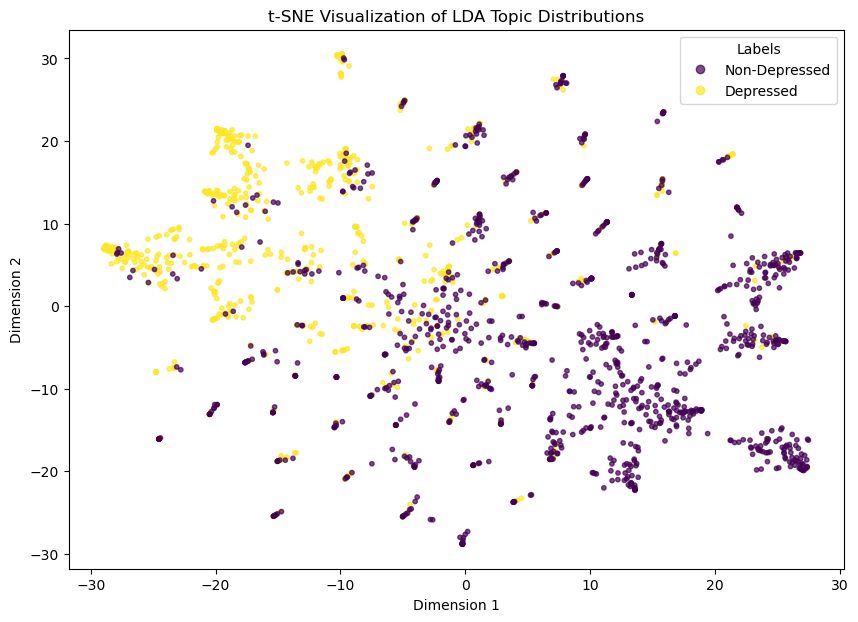

LDA pipeline complete.
Generating Word Clouds...


AttributeError: 'NoneType' object has no attribute 'show_topic'

In [20]:
lda_extractor = LDAFeatureExtractor(documents, labels, num_topics=20, passes=15)

# Step 2: Run the LDA pipeline to extract topics and features
lda_extractor.run_pipeline()

# Step 3: Retrieve the extracted LDA features
topic_matrix = lda_extractor.topic_distribution_to_matrix()
lda_model = lda_extractor.lda_model
corpus = lda_extractor.corpus
dictionary = lda_extractor.dictionary


lda_analyzer = LDAFeatureAnalyzer(lda_extractor)
lda_analyzer.run_analysis(perplexity=50, n_iter=500, n_clusters=5, labels=labels)


